# Closed Source Model Summarization

### Install & Import Necessary Libraries

In [1]:
import os
import platform
import subprocess
import time
import sys

import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')

sys.path.append('../')
from helper.SummarizationMetrics import SummarizationMetrics
from helper.chatgpt_automation import ChatGPTAutomation, split_text_into_chunks
from helper.bard_automation import BardAutomation, split_text_into_chunks


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from langchain import LLMChain, HuggingFacePipeline

from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

from sentence_transformers import SentenceTransformer, util
from scipy.signal import argrelextrema
from sklearn.cluster import KMeans


[nltk_data] Downloading package punkt to C:\Users\Zhang
[nltk_data]     Xiang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Zhang
[nltk_data]     Xiang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Closed Source Models -  WEB Version

**ChatGPT & Bard Model**

| Model | Description | Training Data | Strengths | Weaknesses | Use Cases |
| --- | --- | --- | --- | --- | --- |
| **GPT-3.5-turbo (ChatGPT)** | A cost-effective language model by OpenAI, optimized for chat applications. | Web text and code | Generating creative text formats, translating languages, and writing different kinds of creative content | Sometimes makes mistakes | Chatbots, content creation, translation |
| <s> **PaLM2 (Bard)** </s> | Google's versatile large language model, capable of handling a wide range of tasks. | Books, articles, code, and other forms of text | Answering questions in an informative way, even if they are open ended, challenging, or strange | Can be slow | Research, education, customer service |
|  **Gemini Pro (Bard)** | Google's latest AI model, built upon PaLM2's foundation with additional capabilities in reasoning, planning, and understanding. | Similar to PaLM2. However, it also incorporates additional real-world data to enhance its capabilities|  - Faster and more efficient than PaLM2 <br> - Improved capabilities in reasoning, planning, and understanding <br> - Able to perform a wider range of tasks with greater accuracy | - Still under development,may require more computational resources than PaLM2 |  Research, education, customer service |


Google Bard was updated with the Gemini large language model in 13th December 2023.

Gemini was trained on Google's Tensor Processing Units (TPU), and is faster and cheaper to run than Google's previous PaLM, making the model far more efficient.

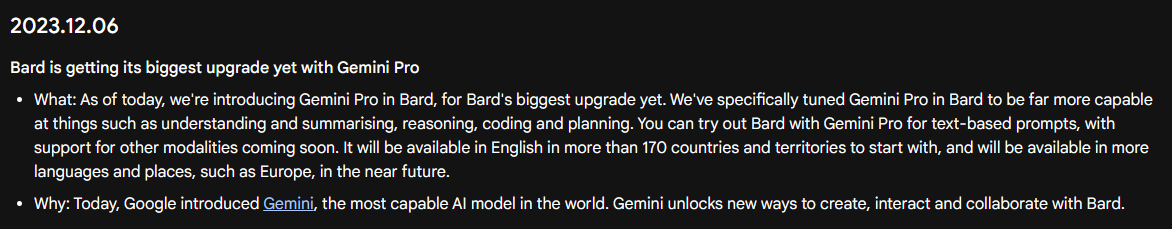

However we will be using the Gemini Pro version

**Gemini Pro vs Gemini Ultra Capabilities**

**Gemini Pro**:
- Focuses on advanced reasoning, planning, and understanding.
- Improved in handling complex situations in prompt.
- Has improved factual accuracy due to access to real-world data.

**Gemini Ultra (Not Available - Cost)**:
- Can process and generate not just text and code, but also images, audio video and more.
- Aims to provide more comprehensive and nuanced responses to complex questions.

**Additional Info:**

The most powerful version of Gemini AI, according to Google, outperforms ChatGPT on over 30 out of 32( around 90%) academic benchmarks, including 10 of 12 popular text and reasoning benchmarks, 9 of 9 image understanding benchmarks, 6 of 6 video understanding benchmarks, and 5 of 5 speech recognition and speech translation benchmarks

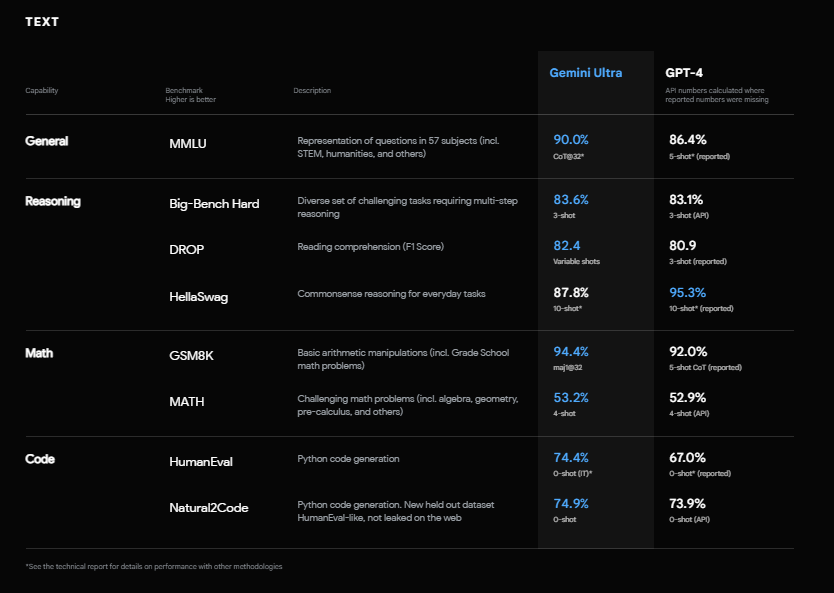

DeepMind Google: https://deepmind.google/technologies/gemini/#capabilities

In [2]:
df = pd.read_excel("../Data/tib_test.xlsx")

df_test = df.head(5)

df_test

,summary,transcript
0,A firsthand look at efforts to improve diversi...,All right. So our next talk is called Hacking...
1,It is certainly a time of discovery- though th...,"Welcome, DEF CON 28, the Do No Harm panel. Th..."
2,Roman Architecture (HSAR 252) Professor Kleine...,Good morning. As you can see from the title o...
3,Stochastic rewriting systems evolving over gra...,"Thank you very much, first important question..."
4,"In typical military operations, the advantage ...",I was great to be with all of you today. I sa...


In [3]:
df_scores = pd.DataFrame(columns=['model', 'method', 'max_tokens' ,'transcript','original summary', 'summary', 'rouge','bert_score', 'bleu', 'time_taken', 'grammar', 'readability'])

#### Helper Function

In [4]:
def summ_pipeline(model, tokenizer, chain_type, max_length, prompt=False):
  pipeline = transformers.pipeline(
      "summarization",
      model=model,
      tokenizer=tokenizer,
      torch_dtype=torch.bfloat16,
      trust_remote_code=True,
      device_map="auto",
      max_length=max_length,
      do_sample=True,
      top_k=10,
      num_return_sequences=1,
      eos_token_id=tokenizer.eos_token_id,
  )
  llm = HuggingFacePipeline(pipeline = pipeline)

  if chain_type == "map_reduce":
    if prompt:
      prompt_template = """Summarize this: ```{text}```"""
      prompt_message = PromptTemplate(template=prompt_template, input_variables=["text"])
      
      summary_chain = load_summarize_chain(llm=llm, chain_type=chain_type, token_max=max_length, prompt=prompt_message)
    else:
      summary_chain = load_summarize_chain(llm=llm, chain_type=chain_type, token_max=max_length)
  else:
    # can't get it to work with refine and stuff, think they updated the library but no documentation
    # on how to set token_max
    summary_chain = load_summarize_chain(llm=llm, chain_type=chain_type)
  return summary_chain

In [5]:
# Order sentence by length and get top important/longest sentences
def text_rank_summary(text, num_sentences=20):
    # Tokenize sentences and words
    sentences = sent_tokenize(text)
    words = [word_tokenize(sentence) for sentence in sentences]

    # Remove stopwords and punctuation, and lowercase the words
    stop_words = set(stopwords.words('english'))
    filtered_words = [[word.lower() for word in words if word.isalnum() and word.lower() not in stop_words] for words in words]

    # Calculate word frequency
    word_freq = FreqDist([word for sentence in filtered_words for word in sentence])

    # Calculate sentence scores based on word frequency
    sentence_scores = {}
    for i, sentence in enumerate(filtered_words):
        sentence_scores[i] = sum([word_freq[word] for word in sentence])

    # Sort sentences by score in descending order
    sorted_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)

    # Generate the summary
    selected_sentences = [sentences[i] for i in sorted_sentences[:num_sentences]]
    final_summary = ' '.join(selected_sentences)

    return final_summary

In [6]:
def getParagraphs(model, sentences):
    # Embed sentences
    embeddings = model.encode(sentences)

    # Create similarities matrix
    similarities = util.pytorch_cos_sim(embeddings, embeddings).numpy()

    def rev_sigmoid(x: float) -> float:
        return 1 / (1 + math.exp(0.5 * x))

    def activate_similarities(similarities: np.array, p_size=10) -> np.array:
        # To create weights for sigmoid function, we first create a space.
        x = np.linspace(-10, 10, p_size)
        y = np.vectorize(rev_sigmoid)  # Apply activation function
        activation_weights = np.pad(y(x), (0, similarities.shape[0] - p_size))

        diagonals = [similarities.diagonal(each) for each in range(0, similarities.shape[0])]
        diagonals = [np.pad(each, (0, similarities.shape[0] - len(each))) for each in diagonals]
        diagonals = np.stack(diagonals)
        diagonals = diagonals * activation_weights.reshape(-1, 1)
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

    activated_similarities = activate_similarities(similarities, p_size=10)

    minmimas = argrelextrema(activated_similarities, np.less, order=2)

    split_points = [each for each in minmimas[0]]
    paragraphs = []
    paragraph = ''
    for num, each in enumerate(sentences):
        paragraph += each
        if num in split_points:
            paragraphs.append(paragraph)
            paragraph = ''

    return paragraphs

def getImportantParagraphs(vectors, paragraphs, num_clusters=11):
    # need to split before embed docs then kmeans to see which one doesn't need to be summarized etc.
    # bcs we dh predefined pages or paragraphs it makes it abit more complicated
    # aft picking the most impt runs, do map reduce on those to see if it gets a better summary
    num_clusters = 11

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

    # Find the closest embeddings to the centroids

    # Create an empty list that will hold your closest points
    closest_indices = []

    # Loop through the number of clusters you have
    for i in range(num_clusters):

        # Get the list of distances from that particular cluster center
        distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

        # Find the list position of the closest one (using argmin to find the smallest distance)
        closest_index = np.argmin(distances)

        # Append that position to your closest indices list
        closest_indices.append(closest_index)

    selected_indices = sorted(closest_indices)
    return [paragraphs[doc] for doc in selected_indices]

In [7]:
def kill_chrome_processes():
    system_platform = platform.system()

    if system_platform == 'Windows':
        try:
            # Execute taskkill command to kill all chrome.exe processes on Windows
            subprocess.run(['taskkill', '/F', '/IM', 'chrome.exe'], check=True)
            print("Successfully terminated all chrome.exe processes.")
        except subprocess.CalledProcessError as e:
            print(f"Error terminating chrome.exe processes: {e}")
    else:
        print("Unsupported platform. This code is designed for Windows.")

#### Web Version ChatGPT & Bard

Not Necessary to test this anymore.

In [8]:
# chatgpt responses on map reduce


# Call the function to terminate chrome.exe processes
kill_chrome_processes()


chrome_path = r'"C:\Program Files\Google\Chrome\Application\chrome.exe"'
chatgpt = ChatGPTAutomation(chrome_path)

# loop through each row of df and get the summary

for index, row in df_test.iterrows():

    model_name = "gpt-3.5-turbo-1106 - web"
    method = "MapReduce"
    
    # get the summary
    start_time = time.time()
    max_tokens = 4000
    # Split the text into chunks below 4K tokens.
    chunks = split_text_into_chunks(row['transcript'], max_tokens)

    # For every text file, split into chunks then process each chunks to summary before getting a summary of those chunks
    chunk_responses = []
    for i, chunk in enumerate(chunks):
        chatgpt.send_prompt_to_chatgpt(chunk)

        # trim spaces
        chunk = chunk.strip()

        # Retrieve the last response from ChatGPT
        response = chatgpt.return_last_response()
        print(response)
        chunk_responses.append(response)
    
    # Join all the chunks responses into one stringy
    summary = ' '.join(chunk_responses)
    chatgpt.send_prompt_to_chatgpt(summary)
    summary = chatgpt.return_last_response()

    print("post summary:", summary)

    end_time = time.time()
    elapsed_time = end_time - start_time

    metrics = SummarizationMetrics(row['summary'], summary)

    
    new_result = {
        'model': model_name,
        'method': method,
        'max_tokens': max_tokens,
        'transcript': row['transcript'],
        'original summary': row['summary'],
        'summary': summary,
        'rouge': metrics.rouge_scores(),
        'bert_score': metrics.bert_score(),
        'bleu': metrics.bleu_score(),
        'time_taken': elapsed_time,
        'grammar': metrics.grammar_check(),
        'readability': metrics.readability_index()
    }


    new_row = pd.DataFrame([new_result])

    df_scores = pd.concat([df_scores, new_row], ignore_index=True)

kill_chrome_processes()


Successfully terminated all chrome.exe processes.
You need to manually complete the log-in or the human verification if required.
Continuing with the automation process...
TLDR in 200 words, without bullet points:All right. So our next talk is called Hacking Diversity, where we basically tried to treat a really awkward question about the spaces that we move in here, which is that we really have these ideas about inclusion and diversity, but in the end, most of the people that come just look like me. And in open source, most people look like me. And this is extremely strange, right? Because we have all of these ideas about diversity and everything. And today we try to answer the question, why this happens and maybe what we can do about it. Our speaker for this is Professor Christina Tamba-Hester. She\'s a professor at the University of Southern California, I think. And today she is showing essentially a condensed version of a book that she just wrote called Hacking Diversity. And I\'m r

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 221.38it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.84 seconds, 0.35 sentences/sec


C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_3448\1409891606.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_scores = pd.concat([df_scores, new_row], ignore_index=True)


TLDR in 200 words, without bullet points:Welcome, DEF CON 28, the Do No Harm panel. This is a healthcare security conversation. And for the next 45 minutes, followed by a 45 minute Q&A, you\'re gonna hear from some of the world\'s top experts on the healthcare cybersecurity space. Welcome. Thanks, Quadi. I\'m Replicant. We\'re going to get out of the way here in just a moment and introduce you to our panelists, but obviously a little bit different of a venue for us than the last couple of years. We hope that everyone is staying safe and healthy, and we\'re thinking of you and look forward to when we can hang out together in person. Without any further ado, I\'m gonna let our panelists take it away and say hi. Hi, everyone. My name is Ash Left. I am a biochemist, a computer scientist, and an electrical engineer. I work at a medical device firm called Starfish in Canada, and I\'m a suffer engineer there and an advocate for security and privacy. I think that means that I\'m next. So I don

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 250.14it/s]


done in 2.92 seconds, 0.34 sentences/sec
TLDR in 200 words, without bullet points:Good morning. As you can see from the title of today\'s lecture, Habitats at Herculaneum and Early Roman Interior Decoration, we\'re going to be concentrating, once again, at least in the first half of the lecture, on domestic architecture in Campania. We\'re going to look at several houses in Herculaneum, and then we\'re going to move from there to begin our discussion of early Roman interior decoration, namely the first and second styles of Roman wall painting. And what you\'ll see makes them particularly relevant to what we\'ve been discussing thus far this term is the fact that in both the first and second styles, architecture is depicted in these paintings, and we\'re going to see some very interesting relationships between that and the built monuments that we\'ve talked about thus far this semester. Just to remind you of the location of Herculaneum, which is usually called the sister city of Pompeii

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.44it/s]


done in 2.14 seconds, 0.47 sentences/sec
TLDR in 200 words, without bullet points:Thank you very much, first important question you can see the slides, hopefully. Yes, we can see you. Yes. Can I start? Should I wait for the minute? No, no, it is a... You can begin now if you want, if you wish. Thank you very much, Jaan, also the organizers for this invitation. It\'s always very nice to be at CUP now virtually, but I hope at least this way some more people can participate. And the talk I would like to give today is about a topic which I think is quite the spirit of CUP, because it is about this type of research which tries to make sense of the deeper links, the mathematical links between approaches to manipulation of graph-like structures and computer science, mathematical physics and mathematics. So, I mean, of course, every of these disciplines has many, many examples of situations where it is meaningful to look at these types of manipulations. For example, the very simplest such is d

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 199.26it/s]


done in 3.07 seconds, 0.33 sentences/sec
TLDR in 200 words, without bullet points:I was great to be with all of you today. I saw that a few of you last night had one of those shots in one of those rooms. I\'m really pleased to be here. I\'m glad to see a good crowd. This isn\'t my first deaf competition, my first time speaking. And Nico said that the way it was listed didn\'t have enough pizzazz. So she put from nuclear to cyber alternative approaches. So I want to make sure I get the nuclear part in so you don\'t feel like you wasted your time or wasted your ticket here. So when I was in the military, my primary business was doing nuclear ops. But interestingly enough, when the Air Force stood up the cyber mission, they gave that mission to my command not because they thought it was like nuclear, but because nuclear was a global mission and they saw the cyber as a global mission. But what I want to talk to you about today is that we somehow are quite often constrained the way we think

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


done in 2.24 seconds, 0.45 sentences/sec
Successfully terminated all chrome.exe processes.


In [9]:
df_scores

,model,method,max_tokens,transcript,original summary,summary,rouge,bert_score,bleu,time_taken,grammar,readability
0,gpt-3.5-turbo-1106 - web,MapReduce,4000,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,The speaker introduces the talk on Hacking Div...,"[{'rouge-1': {'r': 0.2857142857142857, 'p': 0....","([tensor(0.8180)], [tensor(0.8328)], [tensor(0...",5.093405e-79,201.617858,"[Offset 301, length 12, Rule ID: MORFOLOGIK_RU...","score: 18.508762179718513, grade_level: '19'"
1,gpt-3.5-turbo-1106 - web,MapReduce,4000,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,"Welcome to DEF CON 28's Do No Harm panel, a he...","[{'rouge-1': {'r': 0.36220472440944884, 'p': 0...","([tensor(0.8207)], [tensor(0.8204)], [tensor(0...",6.275891e-79,202.141260,"[Offset 149, length 9, Rule ID: MORFOLOGIK_RUL...","score: 16.088816763962708, grade_level: '16'"
2,gpt-3.5-turbo-1106 - web,MapReduce,4000,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,Good morning. In today's lecture on Habitats a...,"[{'rouge-1': {'r': 0.2785714285714286, 'p': 0....","([tensor(0.8476)], [tensor(0.8366)], [tensor(0...",9.805878e-02,203.201517,"[Offset 1036, length 5, Rule ID: MORFOLOGIK_RU...","score: 17.25515262515263, grade_level: '17'"
3,gpt-3.5-turbo-1106 - web,MapReduce,4000,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,Thank you for the introduction. In today's tal...,"[{'rouge-1': {'r': 0.2722222222222222, 'p': 0....","([tensor(0.8339)], [tensor(0.8198)], [tensor(0...",1.197802e-02,204.186420,"[Offset 2596, length 4, Rule ID: MORFOLOGIK_RU...","score: 15.726084656084655, grade_level: '16'"
4,gpt-3.5-turbo-1106 - web,MapReduce,4000,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...","The speaker, familiar with DEF CON's out-of-th...","[{'rouge-1': {'r': 0.1925925925925926, 'p': 0....","([tensor(0.8276)], [tensor(0.8226)], [tensor(0...",1.247085e-78,205.120433,[],"score: 16.120122086570483, grade_level: '16'"


In [19]:
kill_chrome_processes()


chrome_path = r'"C:\Program Files\Google\Chrome\Application\chrome.exe"'
bard = BardAutomation(chrome_path)
# loop through each row of df and get the summary

for index, row in df_test.iterrows():
    model_name = "Gemini Pro - web"
    method = "MapReduce"
    
    # get the summary
    start_time = time.time()

    max_tokens = 9850


    # Split the text into chunks below 4K tokens.
    chunks = split_text_into_chunks(row['transcript'], max_tokens)

    # For every text file, split into chunks then process each chunks to summary before getting a summary of those chunks
    chunk_responses = []
    for i, chunk in enumerate(chunks):
        bard.send_prompt_to_bard(chunk)
        chunk = chunk.strip()

        # Retrieve the last response from bard
        response = bard.return_last_response()
        print(response)
        chunk_responses.append(response)
    
    # Join all the chunks responses into one stringy
    summary = ' '.join(chunk_responses)
    bard.send_prompt_to_bard(summary)
    summary = bard.return_last_response()

    print("post summary:", summary)

    end_time = time.time()
    elapsed_time = end_time - start_time

    metrics = SummarizationMetrics(row['summary'], summary)

    
    new_result = {
        'model': model_name,
        'method': method,
        'max_tokens': max_tokens,
        'transcript': row['transcript'],
        'original summary': row['summary'],
        'summary': summary,
        'rouge': metrics.rouge_scores(),
        'bert_score': metrics.bert_score(),
        'bleu': metrics.bleu_score(),
        'time_taken': elapsed_time,
        'grammar': metrics.grammar_check(),
        'readability': metrics.readability_index()
    }


    new_row = pd.DataFrame([new_result])

    df_scores = pd.concat([df_scores, new_row], ignore_index=True)


kill_chrome_processes()


Successfully terminated all chrome.exe processes.
You need to manually complete the log-in or the human verification if required.
Continuing with the automation process...
TLDR in 200 words, without bullet points:Thank you very much, first important question you can see the slides, hopefully. Yes, we can see you. Yes. Can I start? Should I wait for the minute? No, no, it is a... You can begin now if you want, if you wish. Thank you very much, Jaan, also the organizers for this invitation. It\'s always very nice to be at CUP now virtually, but I hope at least this way some more people can participate. And the talk I would like to give today is about a topic which I think is quite the spirit of CUP, because it is about this type of research which tries to make sense of the deeper links, the mathematical links between approaches to manipulation of graph-like structures and computer science, mathematical physics and mathematics. So, I mean, of course, every of these disciplines has many, m

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\tr

done in 2.49 seconds, 0.40 sentences/sec
TLDR in 200 words, without bullet points:I was great to be with all of you today. I saw that a few of you last night had one of those shots in one of those rooms. I\'m really pleased to be here. I\'m glad to see a good crowd. This isn\'t my first deaf competition, my first time speaking. And Nico said that the way it was listed didn\'t have enough pizzazz. So she put from nuclear to cyber alternative approaches. So I want to make sure I get the nuclear part in so you don\'t feel like you wasted your time or wasted your ticket here. So when I was in the military, my primary business was doing nuclear ops. But interestingly enough, when the Air Force stood up the cyber mission, they gave that mission to my command not because they thought it was like nuclear, but because nuclear was a global mission and they saw the cyber as a global mission. But what I want to talk to you about today is that we somehow are quite often constrained the way we think

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 249.84it/s]


done in 1.35 seconds, 0.74 sentences/sec
Successfully terminated all chrome.exe processes.


In [20]:
df_scores

,model,method,max_tokens,transcript,original summary,summary,rouge,bert_score,bleu,time_taken,grammar,readability
0,gpt-3.5-turbo-1106 - web,MapReduce,4000,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,The speaker introduces the talk on Hacking Div...,"[{'rouge-1': {'r': 0.2857142857142857, 'p': 0....","(tensor([0.8180]), tensor([0.8328]), tensor([0...",5.093405e-79,201.617858,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 18.508762179718513, grade_level: '19'"
1,gpt-3.5-turbo-1106 - web,MapReduce,4000,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,"Welcome to DEF CON 28's Do No Harm panel, a he...","[{'rouge-1': {'r': 0.36220472440944884, 'p': 0...","(tensor([0.8207]), tensor([0.8204]), tensor([0...",6.275891e-79,202.141260,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 16.088816763962708, grade_level: '16'"
2,gpt-3.5-turbo-1106 - web,MapReduce,4000,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,Good morning. In today's lecture on Habitats a...,"[{'rouge-1': {'r': 0.2785714285714286, 'p': 0....","(tensor([0.8476]), tensor([0.8366]), tensor([0...",9.805878e-02,203.201517,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 17.25515262515263, grade_level: '17'"
3,gpt-3.5-turbo-1106 - web,MapReduce,4000,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,Thank you for the introduction. In today's tal...,"[{'rouge-1': {'r': 0.2722222222222222, 'p': 0....","(tensor([0.8339]), tensor([0.8198]), tensor([0...",1.197802e-02,204.186420,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 15.726084656084655, grade_level: '16'"
4,gpt-3.5-turbo-1106 - web,MapReduce,4000,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...","The speaker, familiar with DEF CON's out-of-th...","[{'rouge-1': {'r': 0.1925925925925926, 'p': 0....","(tensor([0.8276]), tensor([0.8226]), tensor([0...",1.247085e-78,205.120433,[],"score: 16.120122086570483, grade_level: '16'"
5,Gemini Pro - web,MapReduce,9850,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,Thank you for providing the additional details...,"[{'rouge-1': {'r': 0.22023809523809523, 'p': 0...","(tensor([0.8172]), tensor([0.8281]), tensor([0...",4.229121e-155,211.349474,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 15.5276421156698, grade_level: '16'"
6,Gemini Pro - web,MapReduce,9850,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,I'm unable to create a TLDR for you. I'm still...,"[{'rouge-1': {'r': 0.03937007874015748, 'p': 0...","(tensor([0.8426]), tensor([0.7883]), tensor([0...",1.710580e-234,211.519830,[],100 words required.
7,Gemini Pro - web,MapReduce,9850,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,You've provided several excellent TL;DR summar...,"[{'rouge-1': {'r': 0.14285714285714285, 'p': 0...","(tensor([0.8263]), tensor([0.8046]), tensor([0...",2.121960e-02,211.833214,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 13.75, grade_level: '14'"
8,Gemini Pro - web,MapReduce,9850,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,That’s not something I’m able to do yet.,"[{'rouge-1': {'r': 0.005555555555555556, 'p': ...","([tensor(0.8354)], [tensor(0.7595)], [tensor(0...",7.380118e-242,211.313763,[],100 words required.
9,Gemini Pro - web,MapReduce,9850,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...",I apologize for the repeated response and conf...,"[{'rouge-1': {'r': 0.06666666666666667, 'p': 0...","([tensor(0.8227)], [tensor(0.7996)], [tensor(0...",3.107672e-155,211.645830,[],"score: 10.144405594405598, grade_level: '10'"


In [21]:
df_scores.to_excel("./result/closed_source_model_web.xlsx", index=False)

In [16]:
df_scores = pd.read_excel("./result/closed_source_model_web.xlsx")
df_scores['max_tokens'] = df_scores['max_tokens'].astype(int)

item_name = 'Gemini Pro - web'
start_row = 8  # Specify the starting row


df_scores = df_scores[(df_scores.index < start_row) | (df_scores['model'] != item_name)]

df_scores


,model,method,max_tokens,transcript,original summary,summary,rouge,bert_score,bleu,time_taken,grammar,readability
0,gpt-3.5-turbo-1106 - web,MapReduce,4000,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,The speaker introduces the talk on Hacking Div...,"[{'rouge-1': {'r': 0.2857142857142857, 'p': 0....","(tensor([0.8180]), tensor([0.8328]), tensor([0...",5.093405e-79,201.617858,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 18.508762179718513, grade_level: '19'"
1,gpt-3.5-turbo-1106 - web,MapReduce,4000,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,"Welcome to DEF CON 28's Do No Harm panel, a he...","[{'rouge-1': {'r': 0.36220472440944884, 'p': 0...","(tensor([0.8207]), tensor([0.8204]), tensor([0...",6.275891e-79,202.141260,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 16.088816763962708, grade_level: '16'"
2,gpt-3.5-turbo-1106 - web,MapReduce,4000,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,Good morning. In today's lecture on Habitats a...,"[{'rouge-1': {'r': 0.2785714285714286, 'p': 0....","(tensor([0.8476]), tensor([0.8366]), tensor([0...",9.805878e-02,203.201517,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 17.25515262515263, grade_level: '17'"
3,gpt-3.5-turbo-1106 - web,MapReduce,4000,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,Thank you for the introduction. In today's tal...,"[{'rouge-1': {'r': 0.2722222222222222, 'p': 0....","(tensor([0.8339]), tensor([0.8198]), tensor([0...",1.197802e-02,204.186420,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 15.726084656084655, grade_level: '16'"
4,gpt-3.5-turbo-1106 - web,MapReduce,4000,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...","The speaker, familiar with DEF CON's out-of-th...","[{'rouge-1': {'r': 0.1925925925925926, 'p': 0....","(tensor([0.8276]), tensor([0.8226]), tensor([0...",1.247085e-78,205.120433,[],"score: 16.120122086570483, grade_level: '16'"
5,Gemini Pro - web,MapReduce,9850,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,Thank you for providing the additional details...,"[{'rouge-1': {'r': 0.22023809523809523, 'p': 0...","(tensor([0.8172]), tensor([0.8281]), tensor([0...",4.229121e-155,211.349474,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 15.5276421156698, grade_level: '16'"
6,Gemini Pro - web,MapReduce,9850,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,I'm unable to create a TLDR for you. I'm still...,"[{'rouge-1': {'r': 0.03937007874015748, 'p': 0...","(tensor([0.8426]), tensor([0.7883]), tensor([0...",1.710580e-234,211.519830,[],100 words required.
7,Gemini Pro - web,MapReduce,9850,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,You've provided several excellent TL;DR summar...,"[{'rouge-1': {'r': 0.14285714285714285, 'p': 0...","(tensor([0.8263]), tensor([0.8046]), tensor([0...",2.121960e-02,211.833214,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 13.75, grade_level: '14'"


C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_44988\1022618527.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


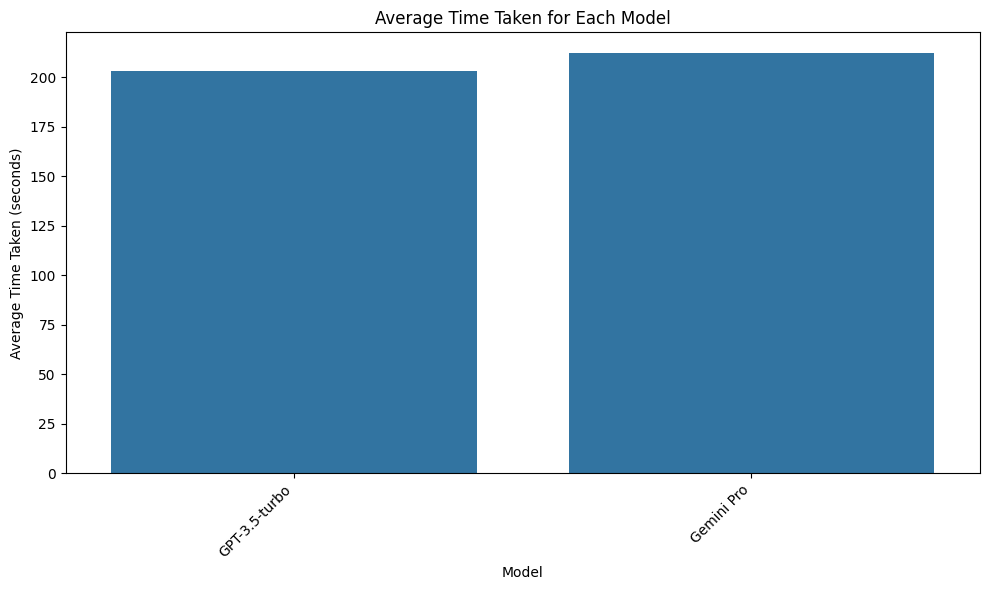

In [46]:
df_avg_time = df_scores.groupby('model')['time_taken'].mean().reset_index()

df_avg_time = df_avg_time.sort_values('time_taken', ascending=True)


plt.figure(figsize=(10, 6))
ax = sns.barplot(x='model', y='time_taken', data=df_avg_time)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Average Time Taken (seconds)')
plt.title('Average Time Taken for Each Model')
plt.tight_layout()
plt.show()

In [47]:
df_scores

,model,method,max_tokens,transcript,original summary,summary,rouge,bert_score,bleu,time_taken,grammar,readability
0,GPT-3.5-turbo,MapReduce,4000,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,"ChatGPT\nThe talk ""Hacking Diversity"" addresse...","[{'rouge-1': {'r': 0.16071428571428573, 'p': 0...","([tensor(0.8471)], [tensor(0.8378)], [tensor(0...",3.412833e-155,201.704379,"[Offset 0, length 7, Rule ID: MORFOLOGIK_RULE_...","score: 18.548346560846564, grade_level: '19'"
1,GPT-3.5-turbo,MapReduce,4000,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,ChatGPT\nWelcome to DEF CON 28's Do No Harm pa...,"[{'rouge-1': {'r': 0.18110236220472442, 'p': 0...","([tensor(0.8309)], [tensor(0.8247)], [tensor(0...",4.342576e-155,202.390215,"[Offset 0, length 7, Rule ID: MORFOLOGIK_RULE_...","score: 17.204711610486893, grade_level: '17'"
2,GPT-3.5-turbo,MapReduce,4000,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,ChatGPT\nThe lecture on Habitats at Herculaneu...,"[{'rouge-1': {'r': 0.18571428571428572, 'p': 0...","([tensor(0.8518)], [tensor(0.8338)], [tensor(0...",6.652284e-02,203.241412,"[Offset 0, length 7, Rule ID: MORFOLOGIK_RULE_...","score: 15.871023830538398, grade_level: '16'"
3,GPT-3.5-turbo,MapReduce,4000,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,ChatGPT\nThe speaker discusses the interdiscip...,"[{'rouge-1': {'r': 0.17777777777777778, 'p': 0...","([tensor(0.8443)], [tensor(0.8183)], [tensor(0...",1.143495e-78,203.928430,"[Offset 0, length 7, Rule ID: MORFOLOGIK_RULE_...","score: 17.259326241134755, grade_level: '17'"
4,GPT-3.5-turbo,MapReduce,4000,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...",ChatGPT\nThe speaker expresses gratitude and i...,"[{'rouge-1': {'r': 0.14814814814814814, 'p': 0...","([tensor(0.8303)], [tensor(0.8176)], [tensor(0...",9.592421e-79,205.166470,"[Offset 0, length 7, Rule ID: MORFOLOGIK_RULE_...","score: 14.361156462585036, grade_level: '14'"
5,Gemini Pro,MapReduce,9850,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,Historical divisions and power imbalances in t...,"[{'rouge-1': {'r': 0.10714285714285714, 'p': 0...","([tensor(0.8593)], [tensor(0.8193)], [tensor(0...",5.889185e-233,211.717463,[],100 words required.
6,Gemini Pro,MapReduce,9850,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,You've already provided a very good TLDR summa...,"[{'rouge-1': {'r': 0.07086614173228346, 'p': 0...","([tensor(0.8179)], [tensor(0.8021)], [tensor(0...",9.327754e-156,211.584397,[],100 words required.
7,Gemini Pro,MapReduce,9850,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,You seem to have provided multiple versions of...,"[{'rouge-1': {'r': 0.02142857142857143, 'p': 0...","([tensor(0.8077)], [tensor(0.7521)], [tensor(0...",2.618915e-158,212.161497,[],100 words required.
8,Gemini Pro,MapReduce,9850,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,I’m still learning to create images so I can’t...,"[{'rouge-1': {'r': 0.016666666666666666, 'p': ...","([tensor(0.8372)], [tensor(0.7639)], [tensor(0...",1.806805e-238,212.320554,"[Offset 35, length 3, Rule ID: COMMA_COMPOUND_...",100 words required.
9,Gemini Pro,MapReduce,9850,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...",You've summarized the speaker's points from va...,"[{'rouge-1': {'r': 0.0962962962962963, 'p': 0....","([tensor(0.8117)], [tensor(0.8027)], [tensor(0...",2.932153e-155,212.550999,"[Offset 215, length 14, Rule ID: CYBER_COMPOUN...","score: 12.744285714285713, grade_level: '13'"


C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_44988\3225679571.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_44988\3225679571.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_44988\3225679571.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


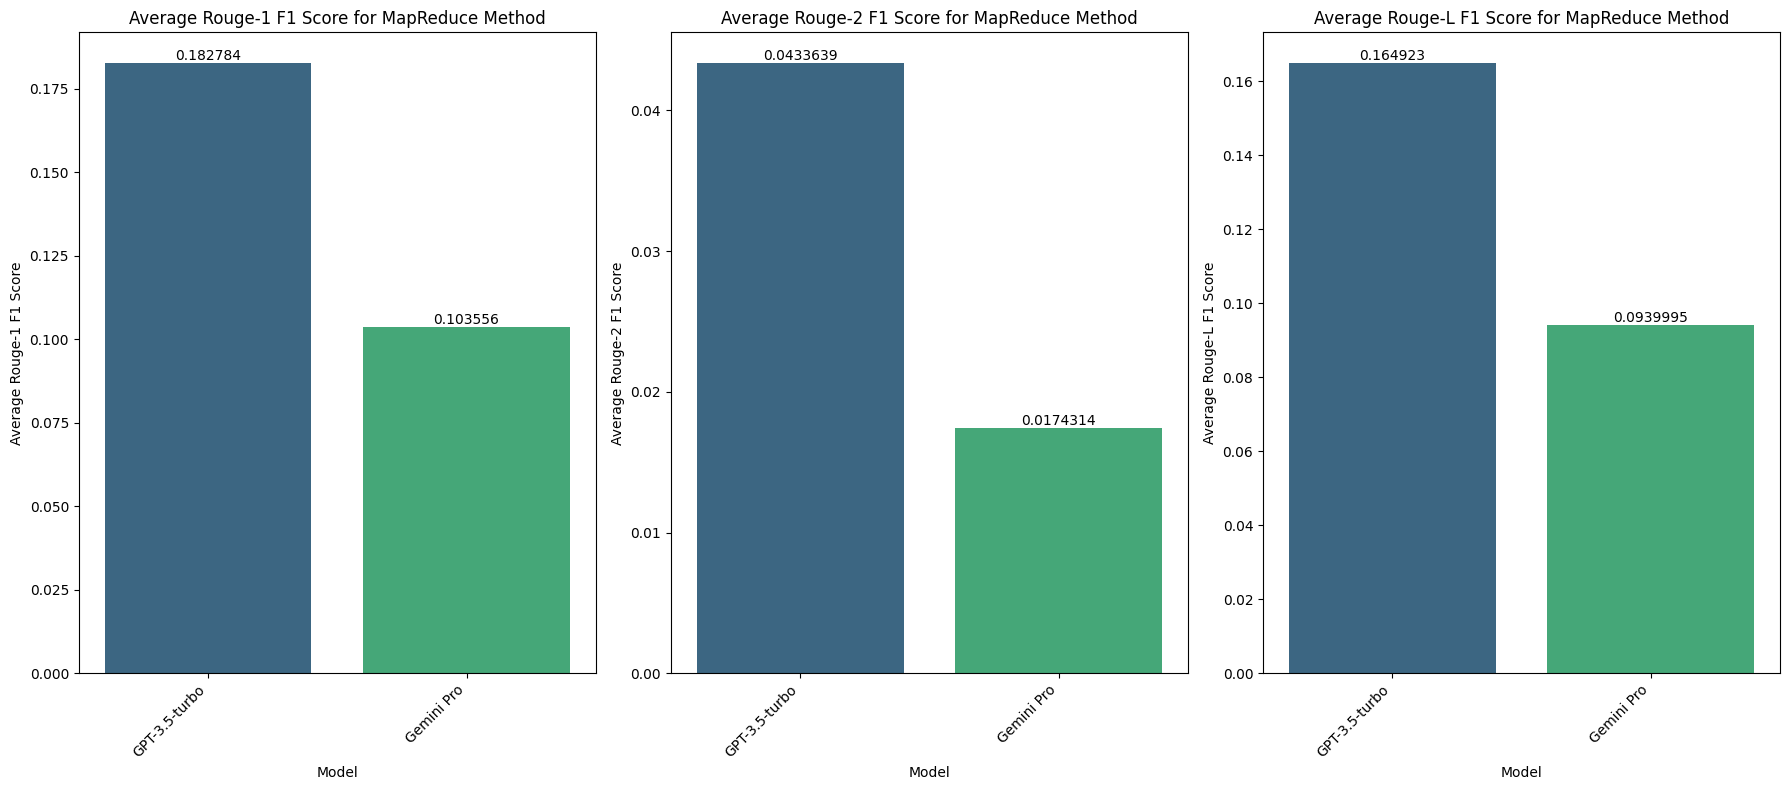

In [17]:
# # Filter removed models
# df_scores = df_scores[df_scores['model'].isin(df_avg_last_f1['model'])]

# Convert string representation of dict to a dictionary
df_scores['rouge_scores'] = df_scores['rouge'].apply(lambda x: x[0])
df_scores['rouge_scores'] = df_scores['rouge'].apply(lambda x: eval(x)[0])


# Extract Rouge-1, Rouge-2, and Rouge-L F1 scores from the dictionary
df_scores['rouge-1_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-1']['f'])
df_scores['rouge-2_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-2']['f'])
df_scores['rouge-l_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-l']['f'])

# Filter data for MapReduce method
df_scores_mapreduce = df_scores[(df_scores['method'] == 'MapReduce')]

# Calculate the average of Rouge-1, Rouge-2, and Rouge-L F1 scores for each model
avg_rouge1 = df_scores_mapreduce.groupby('model')['rouge-1_f'].mean().reset_index()
avg_rouge2 = df_scores_mapreduce.groupby('model')['rouge-2_f'].mean().reset_index()
avg_rouge_l = df_scores_mapreduce.groupby('model')['rouge-l_f'].mean().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# Plot Charts
sns.barplot(x='model', y='rouge-1_f', data=avg_rouge1, palette='viridis', ax=axes[0], hue='model')
axes[0].set_title('Average Rouge-1 F1 Score for MapReduce Method')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Average Rouge-1 F1 Score')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
for container in axes[0].containers:
    axes[0].bar_label(container)




sns.barplot(x='model', y='rouge-2_f', data=avg_rouge2, palette='viridis', ax=axes[1], hue='model')
axes[1].set_title('Average Rouge-2 F1 Score for MapReduce Method')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Average Rouge-2 F1 Score')
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
for container in axes[1].containers:
    axes[1].bar_label(container)



sns.barplot(x='model', y='rouge-l_f', data=avg_rouge_l, palette='viridis', ax=axes[2], hue='model')
axes[2].set_title('Average Rouge-L F1 Score for MapReduce Method')
axes[2].set_xlabel('Model')
axes[2].set_ylabel('Average Rouge-L F1 Score')
axes[2].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
for container in axes[2].containers:
    axes[2].bar_label(container)


plt.tight_layout()

plt.show()


#### Temperature Testing

**OpenAI Temperature:**

- The temperature value ranges from 0 to 2. 
- With lower values indicating greater determinism and higher values indicating more randomness.

**VertexAI Temperature:**

- The temperature value ranges from 0 to 1. 
- With lower values indicating greater determinism and higher values indicating more randomness.

For Informative Content: A lower temperature might be preferred to ensure the generated content is precise and relevant.
For Creative Writing or Ideas: A higher temperature can be chosen to encourage the model to produce more diverse and imaginative responses.

In this case, we will focus more on generating informative content instead of creative writing, as it is for user to recap and learning purpose.
Therefore I will conduct testing from a temperature of 0 and 1, and observe the performance change and content generated.

#### Prompt Engineering

Prompt engineering involves crafting effective and precise input prompts to achieve desired outputs from AI models. When it comes to using AI tools like ChatGPT or Bard for generating summaries, prompt engineering becomes crucial.

- **Clarity and specificity**: Crafting a clear and specific prompt helps in informing the AI models specific requirement you are asking.

- **Guidance on length and format**: Can use prompt engineering to guide the AI model on the desired length and format of the summary.

- **Tuning for style and tone**: Have preferences for a particular writing style or tone in the summary

Prompt 1: Write a concise summary of the following: {text}


Prompt 2: 


### Closed Source OpenAI API


**Pricing**

All models are priced per 1,000 tokens and priced differently for model with different capabilities. Tokens are akin to word fragments, where 1,000 tokens approximate 750 words.

Since Some Testing is performed by previous developer, I will only pick some better/new model for comparison.

Below are some Models compared:

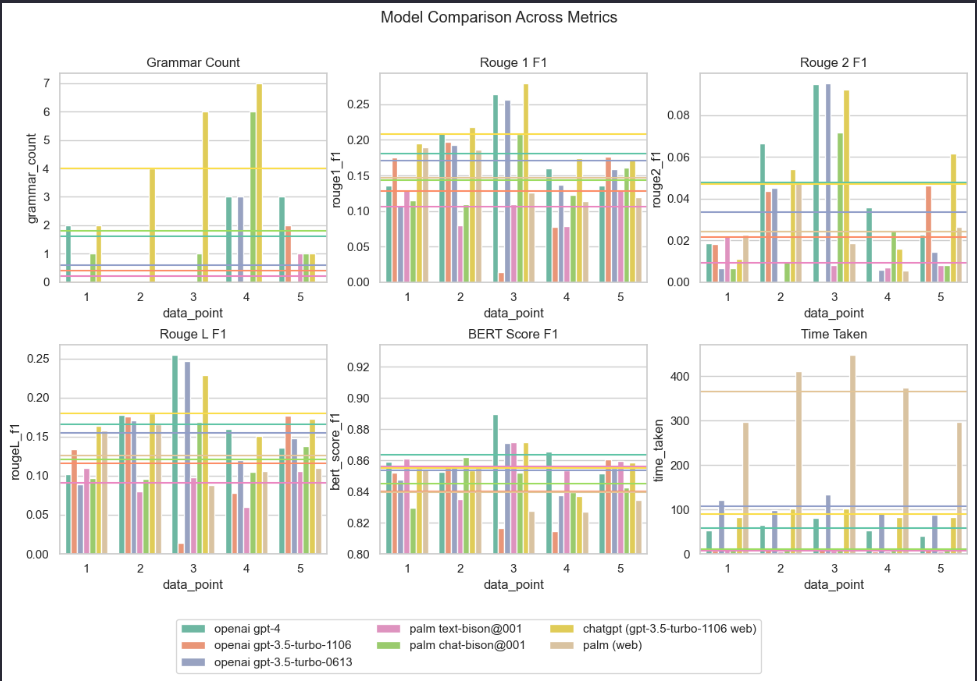

Based on the result above, I will select model below for testing. (Reference: https://openai.com/pricing)


1. **GPT-4 Turbo**

    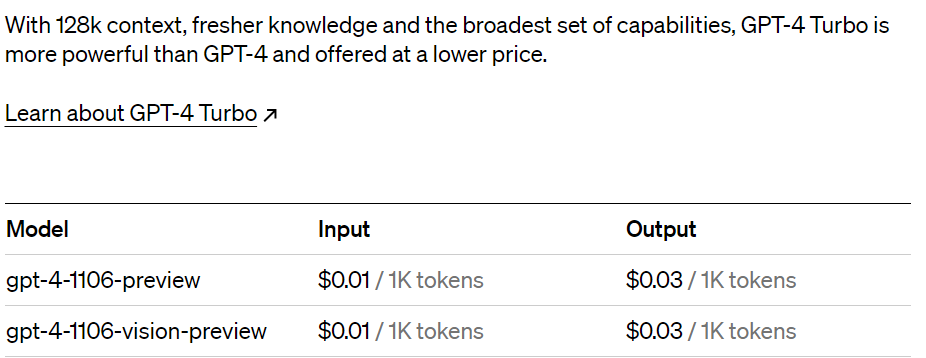

    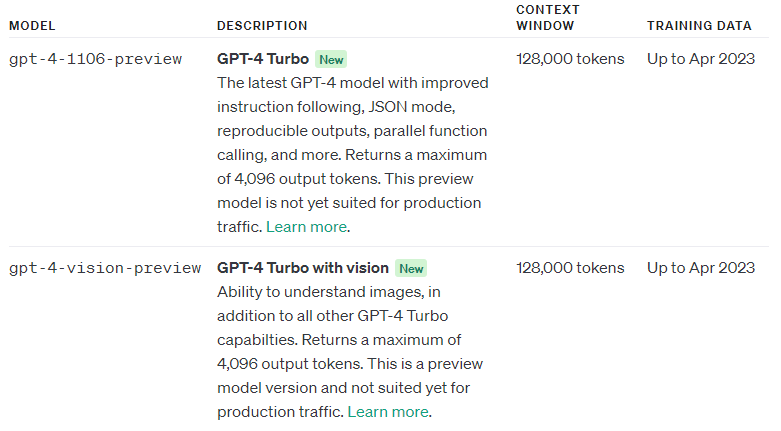


2. **GPT-4**

    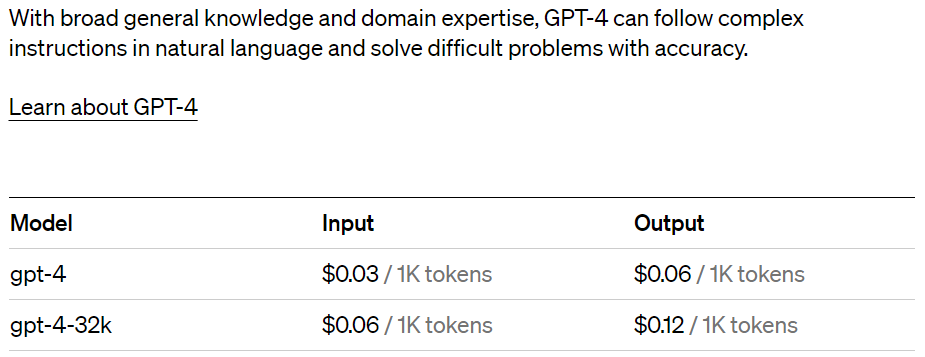

    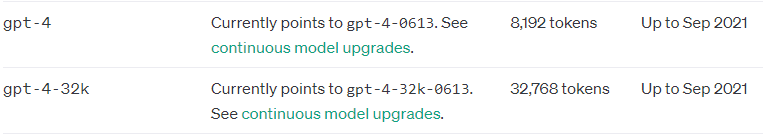



3. **GPT-3.5 Turbo**

    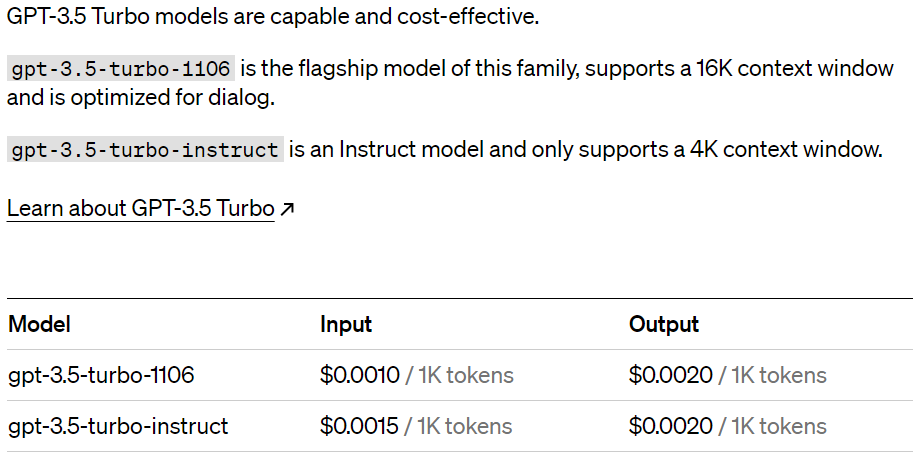

    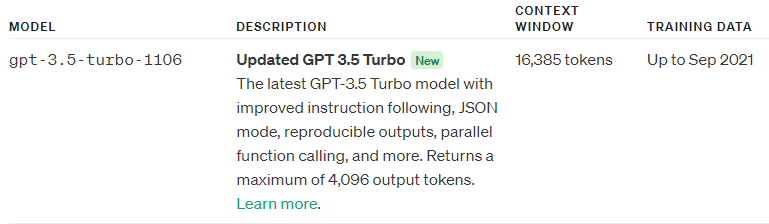



| Model                     | Max Input Tokens | Input Cost per 1000 Tokens | Max Output Tokens | Output Cost per 1000 Tokens |
|---------------------------|------------------|-----------------------------|-------------------|------------------------------|
| gpt-3.5-turbo-1106        | 16385 | $0.0010 | 4096  | $0.0020 |
| gpt-4                     | 8192  | $0.030 | 4096  | $0.060 |
| gpt-4-turbo-1106-preview  | 128000 | $0.010 | 4096 | $0.030 |


Given that 1 token ≈ 3/4 Words

Given the average of text for video up to 2 hours plus is 14250 Words ≈ (14250 / 3/4) Tokens ≈ 19000 Tokens


Given that 1 token ≈ 4 Chars

Given the average of text for video up to 2 hours plus is 80158 Chars ≈ (80158 / 4) Tokens = 20040 Tokens


Given an average tokens for each video is 19000 tokens, below are the cost for a video for each model.

| Model                     | Cost for Input 19000 Tokens | Cost for Output 100 Tokens | Total Cost |
|---------------------------|-----------------------------|-----------------------------|------------|
| gpt-3.5-turbo-1106        | $0.019                      | $0.002                    | $0.0193    |
| gpt-4                     | $0.057                      | $0.006                     | $0.063     |
| gpt-4-turbo-1106-preview  | $0.240                      | $0.003                     | $0.243     |



In [3]:
from os import environ
from langchain.chat_models import ChatOpenAI

from dotenv import load_dotenv

import pandas as pd
import sys
sys.path.append('../')
from helper.SummarizationMetrics import SummarizationMetrics

#### OpenAI Cost Estimation 

Cost on Input Transcript and Output Summary

In [4]:
avg_input_tokens = 19000
avg_output_tokens =  200

print(avg_input_tokens)
print(avg_output_tokens)


19000
200


In [5]:
data = {
    'Model': ['gpt-3.5-turbo-1106', "gpt-3.5-turbo-0125", 'gpt-4', 'gpt-4-turbo-1106-preview', 'gpt-4-0125-preview'],
    'Input Cost per 1000 Tokens': [0.0010, 0.00050 ,0.030, 0.010, 0.010],
    'Output Cost per 1000 Tokens': [0.0020, 0.0015 ,0.060, 0.030, 0.030]
}

df_model_price = pd.DataFrame(data)

df_model_price

,Model,Input Cost per 1000 Tokens,Output Cost per 1000 Tokens
0,gpt-3.5-turbo-1106,0.0010,0.0020
1,gpt-3.5-turbo-0125,0.0005,0.0015
2,gpt-4,0.0300,0.0600
3,gpt-4-turbo-1106-preview,0.0100,0.0300
4,gpt-4-0125-preview,0.0100,0.0300


In [6]:
# Calculate the price for each model
df_price_calculation = pd.DataFrame(columns=['Model', '19000 Tokens Input Cost', '200 tokens Output Cost', 'Total Cost'])

df_price_calculation['Model'] = df_model_price['Model']
df_price_calculation['19000 Tokens Input Cost'] = round((avg_input_tokens / 1000) * df_model_price['Input Cost per 1000 Tokens'], 4)
df_price_calculation['200 tokens Output Cost'] = round((avg_output_tokens / 1000) * df_model_price['Output Cost per 1000 Tokens'], 4)
df_price_calculation['Total Cost'] = round(df_price_calculation['19000 Tokens Input Cost'] + df_price_calculation['200 tokens Output Cost'], 4)

df_price_calculation

,Model,19000 Tokens Input Cost,200 tokens Output Cost,Total Cost
0,gpt-3.5-turbo-1106,0.0190,0.0004,0.0194
1,gpt-3.5-turbo-0125,0.0095,0.0003,0.0098
2,gpt-4,0.5700,0.0120,0.5820
3,gpt-4-turbo-1106-preview,0.1900,0.0060,0.1960
4,gpt-4-0125-preview,0.1900,0.0060,0.1960


In [7]:
df = pd.read_excel("../Data/tib_test.xlsx")

df_test = df.head(5)

df_test

,summary,transcript
0,A firsthand look at efforts to improve diversi...,All right. So our next talk is called Hacking...
1,It is certainly a time of discovery- though th...,"Welcome, DEF CON 28, the Do No Harm panel. Th..."
2,Roman Architecture (HSAR 252) Professor Kleine...,Good morning. As you can see from the title o...
3,Stochastic rewriting systems evolving over gra...,"Thank you very much, first important question..."
4,"In typical military operations, the advantage ...",I was great to be with all of you today. I sa...


In [8]:
load_dotenv(".env", override=True)

True

In [9]:
openai_api_key = environ.get("OPENAI_API_KEY")

# llm = ChatOpenAI(temperature=0, model_name='gpt-3.5-turbo-1106', openai_api_key=openai_api_key)

# llm = ChatOpenAI(temperature=0, model_name='gpt-4', openai_api_key=openai_api_key)

In [11]:
openai_models = {
    "models": [
        # "gpt-3.5-turbo-1106",
        "gpt-3.5-turbo-0125",
        # "gpt-4",
        # "gpt-4-1106-preview",
        "gpt-4-0125-preview",

    ],
    "max_tokens": [
        # 16385,
        16385,
        # 8192,
        # 128000,
        128000,
    ]
}

df_openai_models = pd.DataFrame(openai_models)
df_openai_models

,models,max_tokens
0,gpt-3.5-turbo-0125,16385
1,gpt-4-0125-preview,128000


In [12]:
df_scores = pd.DataFrame(columns=['model', 'method', 'max_tokens', 'num_tokens' ,'transcript', 'original summary' ,'summary', 'grammar', 'readability', 'rouge', 'bert_score', 'time_taken', 'prompt', 'temperature'])
df_scores

,model,method,max_tokens,num_tokens,transcript,original summary,summary,grammar,readability,rouge,bert_score,time_taken,prompt,temperature


In [17]:
df_scores = pd.read_excel("./result/closed_source_model_openai_api.xlsx")

print(df_scores.shape)
df_scores.head(1)

(87, 15)


,model,method,max_tokens,num_tokens,transcript,original summary,summary,rouge,bert_score,bleu,time_taken,grammar,readability,prompt,temperature
0,gpt-3.5-turbo-1106,MapReduce,16385,6827,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,Professor Christina Tamba-Hester's talk on Hac...,"[{'rouge-1': {'r': 0.13690476190476192, 'p': 0...","(tensor([0.8656]), tensor([0.8255]), tensor([0...",8.954086e-156,21.383893,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.,Write a concise summary of the following: {text},0


In [15]:
for model_index, model_row in df_openai_models.iterrows():
    model_name = model_row["models"]
    print(model_name)

    temperature = 0

    llm = ChatOpenAI(temperature=temperature, model_name=model_name, openai_api_key=openai_api_key)
    
    prompt_template = """Write a concise summary of the following: {text}"""
    PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])

    for index, row in df_test.iterrows():
        method = "MapReduce"

        # get the summary
        start_time = time.time()
        num_tokens = llm.get_num_tokens(row['transcript'])
        print("Number of tokens:", num_tokens)

        max_tokens = model_row["max_tokens"]

        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens-100, chunk_overlap=100)
        docs = text_splitter.create_documents([row['transcript']])
        print("Number of chunks:", len(docs))

        # break
        summary_chain = load_summarize_chain(llm=llm, chain_type='map_reduce', token_max=max_tokens , map_prompt=PROMPT)
        summary = summary_chain.run(docs)

        end_time = time.time()
        elapsed_time = end_time - start_time

        metrics = SummarizationMetrics(row['summary'], summary)

        new_result = {
            'model': model_name,
            'method': method,
            'max_tokens': max_tokens,
            'transcript': row['transcript'],
            'original summary': row['summary'],
            'summary': summary,
            'rouge': metrics.rouge_scores(),
            'bert_score': metrics.bert_score(),
            'bleu': metrics.bleu_score(),
            'time_taken': elapsed_time,
            'grammar': metrics.grammar_check(),
            'readability': metrics.readability_index(),
            'num_tokens': num_tokens,
            'prompt': prompt_template,
            'temperature': temperature
        }


        new_row = pd.DataFrame([new_result])

        df_scores = pd.concat([df_scores, new_row], ignore_index=True)

gpt-3.5-turbo-0125
Number of tokens: 6827
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 32.47it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.91 seconds, 0.52 sentences/sec
Number of tokens: 6969
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 492.87it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.28 seconds, 0.78 sentences/sec
Number of tokens: 7628
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


done in 2.02 seconds, 0.50 sentences/sec
Number of tokens: 6855
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 998.64it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.27 seconds, 0.44 sentences/sec
Number of tokens: 7058
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.92it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.57 seconds, 0.64 sentences/sec
gpt-4-0125-preview
Number of tokens: 6827
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 166.59it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.70 seconds, 0.59 sentences/sec
Number of tokens: 6969
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.32it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.28 seconds, 0.78 sentences/sec
Number of tokens: 7628
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 62.33it/s]


done in 2.02 seconds, 0.50 sentences/sec
Number of tokens: 6855
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 100.01it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.25 seconds, 0.44 sentences/sec
Number of tokens: 7058
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 176.63it/s]


done in 1.66 seconds, 0.60 sentences/sec


In [44]:
for model_index, model_row in df_openai_models.iterrows():
    model_name = model_row["models"]
    print(model_name)

    temperature = 0.5

    llm = ChatOpenAI(temperature=temperature, model_name=model_name, openai_api_key=openai_api_key)
    
    prompt_template = "Write a concise summary of the following: {text}"""
    PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])

    for index, row in df_test.iterrows():
        method = "MapReduce"

        # get the summary
        start_time = time.time()
        num_tokens = llm.get_num_tokens(row['transcript'])
        print("Number of tokens:", num_tokens)

        max_tokens = model_row["max_tokens"]

        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens-100, chunk_overlap=100)
        docs = text_splitter.create_documents([row['transcript']])
        print("Number of chunks:", len(docs))

        # break
        summary_chain = load_summarize_chain(llm=llm, chain_type='map_reduce', token_max=max_tokens , map_prompt=PROMPT)
        summary = summary_chain.run(docs)

        end_time = time.time()
        elapsed_time = end_time - start_time

        metrics = SummarizationMetrics(row['summary'], summary)

        new_result = {
            'model': model_name,
            'method': method,
            'max_tokens': max_tokens,
            'transcript': row['transcript'],
            'original summary': row['summary'],
            'summary': summary,
            'rouge': metrics.rouge_scores(),
            'bert_score': metrics.bert_score(),
            'bleu': metrics.bleu_score(),
            'time_taken': elapsed_time,
            'grammar': metrics.grammar_check(),
            'readability': metrics.readability_index(),
            'num_tokens': num_tokens,
            'prompt': prompt_template,
            'temperature': temperature
        }


        new_row = pd.DataFrame([new_result])

        df_scores = pd.concat([df_scores, new_row], ignore_index=True)
        time.sleep(1)

gpt-3.5-turbo-1106
Number of tokens: 6969
Number of chunks: 1


In [37]:
for model_index, model_row in df_openai_models.iterrows():
    model_name = model_row["models"]
    print(model_name)

    temperature = 1

    llm = ChatOpenAI(temperature=temperature, model_name=model_name, openai_api_key=openai_api_key)
    
    prompt_template = """Write a concise summary of the following: {text}"""
    PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])

    for index, row in df_test.iterrows():
        method = "MapReduce"

        # get the summary
        start_time = time.time()
        num_tokens = llm.get_num_tokens(row['transcript'])
        print("Number of tokens:", num_tokens)

        max_tokens = model_row["max_tokens"]

        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens-100, chunk_overlap=100)
        docs = text_splitter.create_documents([row['transcript']])
        print("Number of chunks:", len(docs))

        # break
        summary_chain = load_summarize_chain(llm=llm, chain_type='map_reduce', token_max=max_tokens , map_prompt=PROMPT)
        summary = summary_chain.run(docs)

        end_time = time.time()
        elapsed_time = end_time - start_time

        metrics = SummarizationMetrics(row['summary'], summary)

        new_result = {
            'model': model_name,
            'method': method,
            'max_tokens': max_tokens,
            'transcript': row['transcript'],
            'original summary': row['summary'],
            'summary': summary,
            'rouge': metrics.rouge_scores(),
            'bert_score': metrics.bert_score(),
            'bleu': metrics.bleu_score(),
            'time_taken': elapsed_time,
            'grammar': metrics.grammar_check(),
            'readability': metrics.readability_index(),
            'num_tokens': num_tokens,
            'prompt': prompt_template,
            'temperature': temperature
        }


        new_row = pd.DataFrame([new_result])

        df_scores = pd.concat([df_scores, new_row], ignore_index=True)
        time.sleep(2)


gpt-4-1106-preview
Number of tokens: 6827
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 166.61it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.75 seconds, 0.57 sentences/sec
Number of tokens: 6969
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 111.14it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.35 seconds, 0.74 sentences/sec
Number of tokens: 7628
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 82.26it/s]


done in 2.34 seconds, 0.43 sentences/sec


In [38]:
df_scores

,model,method,max_tokens,num_tokens,transcript,original summary,summary,rouge,bert_score,bleu,time_taken,grammar,readability,prompt,temperature
0,gpt-3.5-turbo-1106,MapReduce,16385,6827,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,Professor Christina Tamba-Hester's talk on Hac...,"[{'rouge-1': {'r': 0.13690476190476192, 'p': 0...","(tensor([0.8656]), tensor([0.8255]), tensor([0...",8.954086e-156,21.383893,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.,Write a concise summary of the following: {text},0
1,gpt-3.5-turbo-1106,MapReduce,16385,7628,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,The speaker discusses important developments i...,"[{'rouge-1': {'r': 0.11428571428571428, 'p': 0...","(tensor([0.8856]), tensor([0.8039]), tensor([0...",6.397942e-157,11.230562,[],100 words required.,Write a concise summary of the following: {text},0
2,gpt-3.5-turbo-1106,MapReduce,16385,6855,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,The main goal of the research is to analyze th...,"[{'rouge-1': {'r': 0.08888888888888889, 'p': 0...","(tensor([0.8576]), tensor([0.7937]), tensor([0...",1.749485e-156,115.299044,[],100 words required.,Write a concise summary of the following: {text},0
3,gpt-3.5-turbo-1106,MapReduce,16385,7058,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...",The presentation challenged traditional approa...,"[{'rouge-1': {'r': 0.1037037037037037, 'p': 0....","(tensor([0.8622]), tensor([0.8058]), tensor([0...",1.587501e-79,14.139802,[],100 words required.,Write a concise summary of the following: {text},0
4,gpt-3.5-turbo-1106,MapReduce,16385,6969,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,The speaker emphasizes the need to take respon...,"[{'rouge-1': {'r': 0.06299212598425197, 'p': 0...","(tensor([0.8376]), tensor([0.7977]), tensor([0...",1.465172e-156,93.767647,[],100 words required.,Write a concise summary of the following: {text},0
5,gpt-4,MapReduce,8192,6969,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,The DEF CON 28 Do No Harm panel discussed the ...,"[{'rouge-1': {'r': 0.14173228346456693, 'p': 0...","(tensor([0.8701]), tensor([0.8204]), tensor([0...",2.587246e-79,11.267398,[],100 words required.,Write a concise summary of the following: {text},0
6,gpt-4-1106-preview,MapReduce,128000,6969,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,"At DEF CON 28, the ""Do No Harm"" panel brought ...","[{'rouge-1': {'r': 0.1968503937007874, 'p': 0....","(tensor([0.8469]), tensor([0.8214]), tensor([0...",5.467525e-79,16.473476,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.,Write a concise summary of the following: {text},0
7,gpt-4,MapReduce,8192,6827,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,"In her talk ""Hacking Diversity"", Professor Chr...","[{'rouge-1': {'r': 0.11904761904761904, 'p': 0...","(tensor([0.8734]), tensor([0.8299]), tensor([0...",2.314046e-79,13.086216,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.,Write a concise summary of the following: {text},0
8,gpt-4,MapReduce,8192,7628,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,The lecture explores the architecture of Hercu...,"[{'rouge-1': {'r': 0.15, 'p': 0.34426229508196...","(tensor([0.8820]), tensor([0.8144]), tensor([0...",2.455021e-02,14.684876,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.,Write a concise summary of the following: {text},0
9,gpt-4,MapReduce,8192,6855,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,The speaker explores 

In [16]:
df_scores['max_tokens'] = df_scores['max_tokens'].astype(int)

df_scores.to_excel("./result/closed_source_model_openai_api.xlsx", index=False)

### Closed Source GCP VertexAI API

**Pricing**

**Prices are listed in US Dollars (USD)**

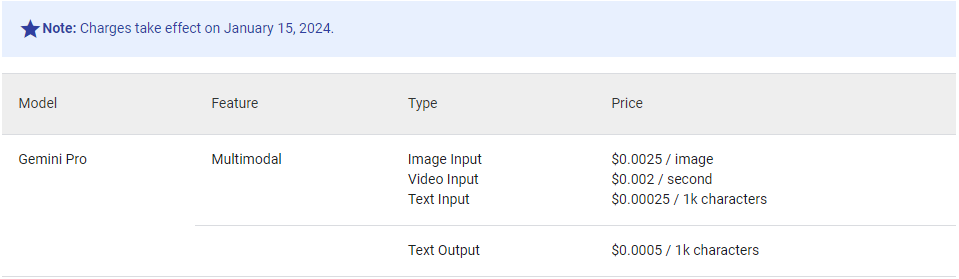

<!-- Conversion to Singapore Dollar (SGD) -->

| Model | Max Input Tokens | Input Cost per 1000 Characters (USD) | Max Output Tokens | Output Cost per 1000 Characters (USD) |
|---|---|---|---|---|
| GEMINI-PRO | 30720 | $0.00025 | 2048 | $0.00050 |
| CHAT-BISON-001 (PaLM 2 Chat (Legacy)) | 4096 | $0.00025 | 1024 | $0.00050 |
| TEXT-BISON-001 (PaLM 2 (Legacy))| 8196 | $0.00025 | 1024 | $0.00050 |

1 Token ~= 4 Characters (CHARS)

| Model | Max Input Tokens | Input Cost per 1000 Tokens (USD) | Max Output Tokens | Output Cost per 1000 Tokens (USD) |
|---|---|---|---|---|
| GEMINI-PRO | 30720 | $0.0010 | 2048 | $0.0020 |
| CHAT-BISON-001 (PaLM 2 Chat (Legacy)) | 4096 | $0.0010 | 1024 | $0.0020 |
| TEXT-BISON-001 (PaLM 2 (Legacy))| 8196 | $0.0010 | 1024 | $0.0020 |

Reference: https://cloud.google.com/vertex-ai/pricing


! If model below was unable to execute try to make authentication connection on Google Colab. 

For Easier connection and authentication to access Google Vertex AI Model <br> Code is implemented at **<bold style="color: yellow">VertexAI and LangChain - V2.ipynb</bold>** on "nyctextsummariser@gmail.com" google colab account.

In [83]:
# !pip install google-generativeai
# !pip install google-cloud-aiplatform

# !pip install langchain-google-genai
# !pip install langchain
# !pip install --upgrade langchain_core

   ---------------------------------------- 0.0/188.2 kB ? eta -:--:--
   --------------------------------------- 188.2/188.2 kB 11.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----------- ---------------------------- 0.6/2.1 MB 19.2 MB/s eta 0:00:01
   ------------------------- -------------- 1.3/2.1 MB 16.9 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 16.4 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.1.3
    Uninstalling langchain-core-0.1.3:
      Successfully uninstalled langchain-core-0.1.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-google-genai 0.0.5 requires langchain-core<0.2,>=0.1, but you have langchain-core 0.0.13 which is incompatible.


In [1]:
from langchain.llms import GooglePalm
from langchain.chat_models import ChatVertexAI
from langchain.llms import VertexAI
import google.generativeai as genai
# from langchain_google_genai import GoogleGenerativeAI



from os import environ
from dotenv import load_dotenv

import pandas as pd
import sys
sys.path.append('../')
from helper.SummarizationMetrics import SummarizationMetrics

c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### GCP VertexAI Cost Estimation 

Cost on Input Transcript and Output Summary

In [6]:
avg_input_tokens = 19000
avg_output_tokens =  200

print(avg_input_tokens)
print(avg_output_tokens)


19000
200


In [7]:
data = {
    'Model': ['gemini-pro', 'chat-bison-001', 'text-bison-001'],
    'Input Cost per 1000 Tokens': [0.001, 0.001, 0.001],
    'Output Cost per 1000 Tokens': [0.002, 0.002, 0.002]
}

df_model_price = pd.DataFrame(data)

df_model_price

,Model,Input Cost per 1000 Tokens,Output Cost per 1000 Tokens
0,gemini-pro,0.001,0.002
1,chat-bison-001,0.001,0.002
2,text-bison-001,0.001,0.002


In [8]:
# Calculate the price for each model
df_price_calculation = pd.DataFrame(columns=['Model', '19000 Tokens Input Cost', '200 tokens Output Cost', 'Total Cost'])

df_price_calculation['Model'] = df_model_price['Model']
df_price_calculation['19000 Tokens Input Cost'] = round((avg_input_tokens / 1000) * df_model_price['Input Cost per 1000 Tokens'], 4)
df_price_calculation['200 tokens Output Cost'] = round((avg_output_tokens / 1000) * df_model_price['Output Cost per 1000 Tokens'], 4)
df_price_calculation['Total Cost'] = round(df_price_calculation['19000 Tokens Input Cost'] + df_price_calculation['200 tokens Output Cost'], 4)

df_price_calculation

,Model,19000 Tokens Input Cost,200 tokens Output Cost,Total Cost
0,gemini-pro,0.019,0.0004,0.0194
1,chat-bison-001,0.019,0.0004,0.0194
2,text-bison-001,0.019,0.0004,0.0194


In [2]:
genai.GenerativeModel()

 genai.GenerativeModel(
   model_name='models/gemini-m',
   generation_config={}.
   safety_settings={}
)

In [4]:
load_dotenv(".env", override=True)

gcp_api_key = environ.get("GCP_API_KEY")

genai.configure(api_key=gcp_api_key)


In [5]:
# List out models available
import pprint
for model in genai.list_models():
    print(model)

Model(name='models/chat-bison-001',
      base_model_id='',
      version='001',
      display_name='PaLM 2 Chat (Legacy)',
      description='A legacy text-only model optimized for chat conversations',
      input_token_limit=4096,
      output_token_limit=1024,
      supported_generation_methods=['generateMessage', 'countMessageTokens'],
      temperature=0.25,
      top_p=0.95,
      top_k=40)
Model(name='models/text-bison-001',
      base_model_id='',
      version='001',
      display_name='PaLM 2 (Legacy)',
      description='A legacy model that understands text and generates text as an output',
      input_token_limit=8196,
      output_token_limit=1024,
      supported_generation_methods=['generateText', 'countTextTokens', 'createTunedTextModel'],
      temperature=0.7,
      top_p=0.95,
      top_k=40)
Model(name='models/embedding-gecko-001',
      base_model_id='',
      version='001',
      display_name='Embedding Gecko',
      description='Obtain a distributed representatio

In [13]:
gcp_models = {

    # Models selected
    "models": [
        "gemini-pro",
        "chat-bison-001",
        "text-bison-001"
    ],

    # Input Token
    "max_tokens": [
        30720,
        4096,
        8196,

    ]
}


df_gcp_models = pd.DataFrame(gcp_models)
df_gcp_models

,models,max_tokens
0,chat-bison-001,4096
1,text-bison-001,8196


In [16]:
df_scores = pd.read_excel("./result/closed_source_model_vertexai_api.xlsx")

df_scores.head(1)

,model,method,max_tokens,num_tokens,transcript,original summary,summary,grammar,readability,rouge,bert_score,time_taken,prompt,temperature,bleu
0,gemini-pro,MapReduce,30720,6983,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,"Professor Christina Tamba-Hester's talk, ""Hack...","[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.,"[{'rouge-1': {'r': 0.09523809523809523, 'p': 0...","(tensor([0.8677]), tensor([0.8245]), tensor([0...",6.114026,Write a concise summary of the following: {text},0,1.069393e-79


In [13]:
SERVICE_ACCOUNT = "nyctextsummariser@gmail.com"
PROJECT_ID = "nyctextsummarizer"
LOCATION = "us-central1"

SERVICE_ACCOUNT_KEY = gcp_api_key

In [94]:
# !gcloud config unset project

Unset property [core/project].


In [105]:
# !gcloud compute zones list

NAME                       REGION                   STATUS  NEXT_MAINTENANCE  TURNDOWN_DATE
us-east1-b                 us-east1                 UP
us-east1-c                 us-east1                 UP
us-east1-d                 us-east1                 UP
us-east4-c                 us-east4                 UP
us-east4-b                 us-east4                 UP
us-east4-a                 us-east4                 UP
us-central1-c              us-central1              UP
us-central1-a              us-central1              UP
us-central1-f              us-central1              UP
us-central1-b              us-central1              UP
us-west1-b                 us-west1                 UP
us-west1-c                 us-west1                 UP
us-west1-a                 us-west1                 UP
europe-west4-a             europe-west4             UP
europe-west4-b             europe-west4             UP
europe-west4-c             europe-west4             UP
europe-west1-b             e

In [106]:
# !gcloud config set "nyctextsummariser@gmail.com"
# !gcloud config set project "nyctextsummarizer"
# !gcloud config set zone "us-central1"


ERROR: (gcloud.config.set) argument VALUE: Must be specified.
Usage: gcloud config set SECTION/PROPERTY VALUE [optional flags]
  optional flags may be  --help | --installation

For detailed information on this command and its flags, run:
  gcloud config set --help
Updated property [core/project].
ERROR: (gcloud.config.set) Section [core] has no property [zone].


In [97]:
# !gcloud config set --help

NAME
    gcloud config set - set a Google Cloud CLI property

SYNOPSIS
    gcloud config set SECTION/PROPERTY VALUE [--installation]
        [GCLOUD_WIDE_FLAG ...]

DESCRIPTION
    gcloud config set sets the specified property in your active configuration
    only. A property governs the behavior of a specific aspect of Google Cloud
    CLI such as the service account to use or the verbosity level of logs. To
    set the property across all configurations, use the --installation flag.
    For more information regarding creating and using configurations, see
    gcloud topic configurations.

    To view a list of properties currently in use, run gcloud config list.

    To unset properties, use gcloud config unset.

    Google Cloud CLI comes with a default configuration. To create multiple
    configurations, use gcloud config configurations create, and gcloud config
    configurations activate to switch between them.

    Note: If you are using Cloud Shell, your gcloud command-line to

In [55]:
# !gcloud auth list

In [13]:
# !gcloud config get account

nyctextsummariser@gmail.com


In [98]:
# !gcloud auth application-default set-quota-project "nyctextsummarizer"
# !gcloud auth login



Credentials saved to file: [C:\Users\Zhang Xiang\AppData\Roaming\gcloud\application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "nyctextsummarizer" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


In [99]:
# !gcloud auth activate-service-account $SERVICE_ACCOUNT --key-file=$SERVICE_ACCOUNT_KEY --project=$PROJECT_ID

In [14]:
# !gcloud auth login


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=RtqDPWVMfsMIRW8YdpBdItwqkybuQL&access_type=offline&code_challenge=j5Zn46p-JIRFtJM9arR5XuIcHoFmsmk5yB0HCNi1CiM&code_challenge_method=S256


You are now logged in as [nyctextsummariser@gmail.com].
Your current project is [nyctextsummarizer].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [15]:
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [109]:
# from IPython.display import Markdown

# model = genai.GenerativeModel('gemini-pro')
# response = model.generate_content("List 5 planets each with an interesting fact")

# Markdown(response.text)

In [21]:
!gcloud auth revoke "nyctextsummariser@gmail.com"


Revoked credentials:
 - nyctextsummariser@gmail.com


                    Credentialed Accounts
ACTIVE  ACCOUNT
        service-vertex-sdk@s1-210896x.iam.gserviceaccount.com
        zhangxiang1121@gmail.com


In [24]:
!gcloud auth application-default login


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=Oafxx0bd4efEoyfAKF4dr8NFysXZUi&access_type=offline&code_challenge=ib6cDGpdw4SENpkbAy_7qDnYpx2lKaEKl8-C19DP454&code_challenge_method=S256


Credentials saved to file: [C:\Users\Zhang Xiang\AppData\Roaming\gcloud\application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "nyctextsummarizer" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the proj

In [18]:
SERVICE_ACCOUNT

'nyctextsummariser@gmail.com'

In [30]:
!gcloud config get project


nyctextsummarizer


In [17]:
# models_to_drop = ["chat-bison@001", "text-bison@001"]
# df_scores = df_scores[~df_scores["model"].isin(models_to_drop)]

# df_scores.head(1)

,model,method,max_tokens,num_tokens,transcript,original summary,summary,grammar,readability,rouge,bert_score,time_taken,prompt,temperature,bleu
0,gemini-pro,MapReduce,30720,6983,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,"Professor Christina Tamba-Hester's talk, ""Hack...","[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.,"[{'rouge-1': {'r': 0.09523809523809523, 'p': 0...","(tensor([0.8677]), tensor([0.8245]), tensor([0...",6.114026,Write a concise summary of the following: {text},0,1.069393e-79
1,gemini-pro,MapReduce,30720,7196,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,The DEF CON 28 Do No Harm panel discussed heal...,[],100 words required.,"[{'rouge-1': {'r': 0.12598425196850394, 'p': 0...","(tensor([0.8749]), tensor([0.8198]), tensor([0...",5.093334,Write a concise summary of the following: {text},0,7.721633e-80
2,gemini-pro,MapReduce,30720,7611,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,"Herculaneum, Pompeii's sister city, is located...","[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.,"[{'rouge-1': {'r': 0.09285714285714286, 'p': 0...","(tensor([0.8375]), tensor([0.7858]), tensor([0...",4.874872,Write a concise summary of the following: {text},0,2.190582e-156
3,gemini-pro,MapReduce,30720,6824,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,The talk explores the mathematical connections...,[],100 words required.,"[{'rouge-1': {'r': 0.08333333333333333, 'p': 0...","(tensor([0.8500]), tensor([0.7963]), tensor([0...",4.832208,Write a concise summary of the following: {text},0,2.059837e-156
4,gemini-pro,MapReduce,30720,7238,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...",A former military official presented a talk on...,[],100 words required.,"[{'rouge-1': {'r': 0.037037037037037035, 'p': ...","(tensor([0.8740]), tensor([0.7981]), tensor([0...",2.656942,Write a concise summary of the following: {text},0,1.338873e-238
15,gemini-pro,MapReduce,30720,6983,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,"In her talk, ""Hacking Diversity,"" Professor C...","[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.,"[{'rouge-1': {'r': 0.07738095238095238, 'p': 0...","(tensor([0.8688]), tensor([0.8247]), tensor([0...",7.709936,Write a concise summary of the following: {text},1,1.739424e-156
16,gemini-pro,MapReduce,30720,7196,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,Optimism is growing in healthcare security as...,[],100 words required.,"[{'rouge-1': {'r': 0.09448818897637795, 'p': 0...","(tensor([0.8552]), tensor([0.8082]), tensor([0...",7.013662,Write a concise summary of the following: {text},1,8.148263e-156
17,gemini-pro,MapReduce,30720,7611,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,The lecture explores domestic architecture in...,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.,"[{'rouge-1': {'r': 0.16428571428571428, 'p': 0...","(tensor([0.8734]), tensor([0.8152]), tensor([0...",5.496190,Write a concise summary of the following: {text},1,9.565803e-03
18,gemini-pro,MapReduce,30720,6824,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,The talk explored the connections between mat...,[],100 words required.,"[{'rouge-1': {'r': 0.05555555555555555, 'p': 0...","(tensor([0.8589]), tensor([0.7926]), tensor([0...",5.600048,Write a concise summary of the following: {text},1,2.206049e-157
19,gemini-pro,MapReduce,30720,7238,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...",The speaker compares nuclear weapons' transfo...,[],

In [19]:
for model_index, model_row in df_gcp_models.iterrows():
    model_name = model_row["models"]
    print(model_name)

    temperature = 0

    if "chat" in model_name.lower():
      llm = ChatVertexAI(temperature=temperature, model=model_name, verbose=True)
    else:
      llm = VertexAI(temperature=temperature, model=model_name, verbose=True)
    
    prompt_template = """Write a concise summary of the following: {text}"""
    PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])

    for index, row in df_test.iterrows():
        method = "MapReduce"

        # get the summary
        start_time = time.time()
        num_tokens = llm.get_num_tokens(row['transcript'])
        print("Number of tokens:", num_tokens)

        max_tokens = model_row["max_tokens"]
        print(max_tokens)

        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens-100, chunk_overlap=100)
        docs = text_splitter.create_documents([row['transcript']])
        print("Number of chunks:", len(docs))

        summary_chain = load_summarize_chain(llm=llm, chain_type='map_reduce', token_max=max_tokens , map_prompt=PROMPT)
        summary = summary_chain.run(docs)

        end_time = time.time()
        elapsed_time = end_time - start_time

        metrics = SummarizationMetrics(row['summary'], summary)

        new_result = {
            'model': model_name,
            'method': method,
            'max_tokens': max_tokens,
            'transcript': row['transcript'],
            'original summary': row['summary'],
            'summary': summary,
            'rouge': metrics.rouge_scores(),
            'bert_score': metrics.bert_score(),
            'bleu': metrics.bleu_score(),
            'time_taken': elapsed_time,
            'grammar': metrics.grammar_check(),
            'readability': metrics.readability_index(),
            'num_tokens': num_tokens,
            'prompt': prompt_template,
            'temperature': temperature
        }


        new_row = pd.DataFrame([new_result])

        df_scores = pd.concat([df_scores, new_row], ignore_index=True)


chat-bison-001


Token indices sequence length is longer than the specified maximum sequence length for this model (6786 > 1024). Running this sequence through the model will result in indexing errors


Number of tokens: 6786
4096
Number of chunks: 2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 242.67it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.76 seconds, 0.57 sentences/sec
Number of tokens: 6971
4096
Number of chunks: 2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.38it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.36 seconds, 0.74 sentences/sec
Number of tokens: 7640
4096
Number of chunks: 2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.20it/s]


done in 2.06 seconds, 0.49 sentences/sec
Number of tokens: 6929
4096
Number of chunks: 2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.68it/s]


done in 2.15 seconds, 0.47 sentences/sec
Number of tokens: 7052
4096
Number of chunks: 2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 250.26it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.41 seconds, 0.71 sentences/sec
text-bison-001
Number of tokens: 6983
8196
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 999.12it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.82 seconds, 0.55 sentences/sec
Number of tokens: 7196
8196
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 249.74it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.35 seconds, 0.74 sentences/sec
Number of tokens: 7611
8196
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 498.61it/s]


done in 2.22 seconds, 0.45 sentences/sec
Number of tokens: 6824
8196
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.12it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.41 seconds, 0.41 sentences/sec
Number of tokens: 7238
8196
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 199.42it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.58 seconds, 0.63 sentences/sec


In [19]:
for model_index, model_row in df_gcp_models.iterrows():
    model_name = model_row["models"]
    print(model_name)

    temperature = 1

    if "chat" in model_name.lower():
      llm = ChatVertexAI(temperature=temperature, model=model_name, verbose=True)
    else:
      llm = VertexAI(temperature=temperature, model=model_name, verbose=True)
    
    prompt_template = """Write a concise summary of the following: {text}"""
    PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])

    for index, row in df_test.iterrows():
        method = "MapReduce"

        # get the summary
        start_time = time.time()
        num_tokens = llm.get_num_tokens(row['transcript'])
        print("Number of tokens:", num_tokens)

        max_tokens = model_row["max_tokens"]
        print(max_tokens)

        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens-100, chunk_overlap=100)
        docs = text_splitter.create_documents([row['transcript']])
        print("Number of chunks:", len(docs))

        summary_chain = load_summarize_chain(llm=llm, chain_type='map_reduce', token_max=max_tokens , map_prompt=PROMPT)
        summary = summary_chain.run(docs)

        end_time = time.time()
        elapsed_time = end_time - start_time

        metrics = SummarizationMetrics(row['summary'], summary)

        new_result = {
            'model': model_name,
            'method': method,
            'max_tokens': max_tokens,
            'transcript': row['transcript'],
            'original summary': row['summary'],
            'summary': summary,
            'rouge': metrics.rouge_scores(),
            'bert_score': metrics.bert_score(),
            'bleu': metrics.bleu_score(),
            'time_taken': elapsed_time,
            'grammar': metrics.grammar_check(),
            'readability': metrics.readability_index(),
            'num_tokens': num_tokens,
            'prompt': prompt_template,
            'temperature': temperature
        }


        new_row = pd.DataFrame([new_result])

        df_scores = pd.concat([df_scores, new_row], ignore_index=True)


gemini-pro
Number of tokens: 6983
30720
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 44.75it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.04 seconds, 0.49 sentences/sec
Number of tokens: 7196
30720
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 453.88it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.37 seconds, 0.73 sentences/sec
Number of tokens: 7611
30720
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 994.38it/s]


done in 2.21 seconds, 0.45 sentences/sec
Number of tokens: 6824
30720
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 200.03it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.60 seconds, 0.38 sentences/sec
Number of tokens: 7238
30720
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 498.91it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.53 seconds, 0.65 sentences/sec
chat-bison-001


Token indices sequence length is longer than the specified maximum sequence length for this model (6786 > 1024). Running this sequence through the model will result in indexing errors


Number of tokens: 6786
4096
Number of chunks: 2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.62it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.71 seconds, 0.58 sentences/sec
Number of tokens: 6971
4096
Number of chunks: 2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.15it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.29 seconds, 0.77 sentences/sec
Number of tokens: 7640
4096
Number of chunks: 2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 334.53it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.04 seconds, 0.49 sentences/sec
Number of tokens: 6929
4096
Number of chunks: 2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 166.61it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.37 seconds, 0.42 sentences/sec
Number of tokens: 7052
4096
Number of chunks: 2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.62it/s]


done in 1.43 seconds, 0.70 sentences/sec
text-bison-001
Number of tokens: 6983
8196
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 17.33it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.83 seconds, 0.55 sentences/sec
Number of tokens: 7196
8196
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 274.10it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.46 seconds, 0.68 sentences/sec
Number of tokens: 7611
8196
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 111.13it/s]


done in 2.21 seconds, 0.45 sentences/sec
Number of tokens: 6824
8196
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 111.12it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.52 seconds, 0.40 sentences/sec
Number of tokens: 7238
8196
Number of chunks: 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 90.91it/s]


done in 2.36 seconds, 0.42 sentences/sec


In [20]:
df_scores

,model,method,max_tokens,num_tokens,transcript,original summary,summary,grammar,readability,rouge,bert_score,time_taken,prompt,temperature,bleu
0,gemini-pro,MapReduce,30720,6983,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,"Professor Christina Tamba-Hester's talk, ""Hack...","[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.,"[{'rouge-1': {'r': 0.09523809523809523, 'p': 0...","(tensor([0.8677]), tensor([0.8245]), tensor([0...",6.114026,Write a concise summary of the following: {text},0,1.069393e-79
1,gemini-pro,MapReduce,30720,7196,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,The DEF CON 28 Do No Harm panel discussed heal...,[],100 words required.,"[{'rouge-1': {'r': 0.12598425196850394, 'p': 0...","(tensor([0.8749]), tensor([0.8198]), tensor([0...",5.093334,Write a concise summary of the following: {text},0,7.721633e-80
2,gemini-pro,MapReduce,30720,7611,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,"Herculaneum, Pompeii's sister city, is located...","[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.,"[{'rouge-1': {'r': 0.09285714285714286, 'p': 0...","(tensor([0.8375]), tensor([0.7858]), tensor([0...",4.874872,Write a concise summary of the following: {text},0,2.190582e-156
3,gemini-pro,MapReduce,30720,6824,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,The talk explores the mathematical connections...,[],100 words required.,"[{'rouge-1': {'r': 0.08333333333333333, 'p': 0...","(tensor([0.8500]), tensor([0.7963]), tensor([0...",4.832208,Write a concise summary of the following: {text},0,2.059837e-156
4,gemini-pro,MapReduce,30720,7238,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...",A former military official presented a talk on...,[],100 words required.,"[{'rouge-1': {'r': 0.037037037037037035, 'p': ...","(tensor([0.8740]), tensor([0.7981]), tensor([0...",2.656942,Write a concise summary of the following: {text},0,1.338873e-238
5,chat-bison@001,MapReduce,4096,6786,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,The talk is about the history of diversity in ...,[],100 words required.,"[{'rouge-1': {'r': 0.06547619047619048, 'p': 0...","(tensor([0.8609]), tensor([0.8094]), tensor([0...",5.773754,Write a concise summary of the following: {text},0,1.958480e-156
6,chat-bison@001,MapReduce,4096,6971,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,Healthcare cybersecurity is a complex issue wi...,[],100 words required.,"[{'rouge-1': {'r': 0.08661417322834646, 'p': 0...","(tensor([0.8700]), tensor([0.8051]), tensor([0...",3.307963,Write a concise summary of the following: {text},0,3.839293e-157
7,chat-bison@001,MapReduce,4096,7640,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,The lecture is about the city of Herculaneum a...,[],100 words required.,"[{'rouge-1': {'r': 0.11428571428571428, 'p': 0...","(tensor([0.9055]), tensor([0.8060]), tensor([0...",3.196498,Write a concise summary of the following: {text},0,2.703009e-03
8,chat-bison@001,MapReduce,4096,6929,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,The talk is about the combinatorial structures...,[],100 words required.,"[{'rouge-1': {'r': 0.044444444444444446, 'p': ...","(tensor([0.8761]), tensor([0.7803]), tensor([0...",2.540207,Write a concise summary of the following: {text},0,3.264868e-164
9,chat-bison@001,MapReduce,4096,7052,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...",The speaker discussed the different perspectiv...,"[Match({'ruleId': 'CYBER_COMPOUNDS', 'message'...",100 words required.,"[{'rouge-1': {'r'

In [21]:
df_scores.to_excel("./result/closed_source_model_vertexai_api.xlsx", index=False)